In [22]:
import nvtx
import vio_ort
import matplotlib.pyplot as plt
import os
import json
import cv2
import concurrent.futures
import threading
from collections import defaultdict
import plotly.graph_objects as go

In [23]:
with nvtx.annotate("Initialize VIO and Parameters", color="blue"):
	odometry = vio_ort.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)

	set_dir = '2024_12_15_15_31_8_num_3'

	json_files = [f for f in os.listdir(set_dir) if f.endswith('.json')]
	json_files.sort()

	start = 0
	count_json = len(json_files)

	lat_VIO, lon_VIO = [], []
	lat_GPS, lon_GPS = [], []
	alt_VIO, alt_GPS = [], []

In [24]:
with nvtx.annotate("Initialize Error Collection", color="red"):
	fails_collect = defaultdict(lambda: {'num': 0, 'files': []})
	lock = threading.Lock()

In [25]:
@nvtx.annotate("Register Error", color="red")
def register_error(error_type, filename):
	with lock:
		fails_collect[error_type]['num'] += 1
		fails_collect[error_type]['files'].append(filename)

In [26]:
@nvtx.annotate("Process File", color="blue")
def process_file(filename):
	with nvtx.annotate("Load JSON", color="cyan"):
		try:
			with open(os.path.join(set_dir, filename), 'r') as file:
				data = json.load(file)
		except json.JSONDecodeError:
			register_error("JSON decode error", filename)
			return
		except Exception:
			register_error("Processing error", filename)
			return

	with nvtx.annotate("Validate Data", color="magenta"):
		if 'GNRMC' not in data or 'VIO' not in data:
			register_error("Missing GNRMC or VIO", filename)
			return

		if data['GNRMC'].get('status') != 'A':
			register_error("GNRMC status not 'A'", filename)
			return

	with nvtx.annotate("Load Image", color="yellow"):
		img_path = os.path.join(set_dir, os.path.splitext(filename)[0] + '.jpg')
		if not os.path.exists(img_path):
			register_error("Image not found", filename)
			return

		image = cv2.imread(img_path)
		if image is None:
			register_error("Failed to load image", filename)
			return
		
	with nvtx.annotate("Process VIO", color="green"):
		try:
			result_vio = odometry.add_trace_pt(image, data)
			if 'lat' not in result_vio or 'lon' not in result_vio:
				register_error("VIO result missing 'lat' or 'lon'", filename)
				return

			with lock:
				lat_VIO.append(result_vio['lat'])
				lon_VIO.append(result_vio['lon'])
				alt_VIO.append(data['VIO']['alt'])
		except Exception as e:
			register_error("VIO processing error", filename)
			return

	with nvtx.annotate("Process GPS", color="orange"):
		try:
			with lock:
				lat_GPS.append(data['GNRMC'].get('lat', 0.0))
				lon_GPS.append(data['GNRMC'].get('lon', 0.0))
				alt_GPS.append(data['GPS_RAW_INT']['alt'])
		except KeyError:
			register_error("GPS data missing", filename)

Путем перебора наибольшая выгода при 6 потоках

In [27]:
def main():
	workers = 6
	with nvtx.annotate("ThreadPool Execution", color="purple"):
		with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as executor:
			executor.map(process_file, json_files[start:start + count_json])
	
	# Вывод отчетности
	with nvtx.annotate("Report Errors", color="pink"):
		print("\nError Report:")
		for error_type, error_info in fails_collect.items():
			print(f"{error_type} - {error_info['num']} occurrences")
			print(f"Files: {', '.join(error_info['files'])}")
			print()

In [28]:
with nvtx.annotate("Main Function", color="darkviolet"):
	main()


Error Report:
GNRMC status not 'A' - 64 occurrences
Files: 1734247868001.json, 1734247868492.json, 1734247869167.json, 1734247868955.json, 1734247869318.json, 1734247869736.json, 1734247869446.json, 1734247869585.json, 1734247870290.json, 1734247868806.json, 1734247869909.json, 1734247870585.json, 1734247871308.json, 1734247870836.json, 1734247871552.json, 1734247871436.json, 1734247871849.json, 1734247872226.json, 1734247871712.json, 1734247872566.json, 1734247871966.json, 1734247873120.json, 1734247871036.json, 1734247873324.json, 1734247872080.json, 1734247872872.json, 1734247873960.json, 1734247873713.json, 1734247874271.json, 1734247874117.json, 1734247873449.json, 1734247874807.json, 1734247874672.json, 1734247874401.json, 1734247874935.json, 1734247875056.json, 1734247874538.json, 1734247875727.json, 1734247873828.json, 1734247875331.json, 1734247875452.json, 1734247876037.json, 1734247875599.json, 1734247875875.json, 1734247876167.json, 1734247876438.json, 1734247876282.json, 

In [29]:
with nvtx.annotate("Math coords", color="black"):
	def draw_graph():
		# Шаг 1. Загрузка координат
		gps_lat = lat_GPS.copy()
		gps_lon = lon_GPS.copy()
		vio_lat = lat_VIO.copy()
		vio_lon = lon_VIO.copy()
		gps_alt = alt_GPS.copy()
		vio_alt = alt_VIO.copy()
		
		# Шаг 2. Сохраняем начальные точки (они должны совпадать)
		gps_lon0 = gps_lon[0]
		gps_lat0 = gps_lat[0]
		vio_lon0 = vio_lon[0]
		vio_lat0 = vio_lat[0]
		
		# Шаг 3. Вычисляем средние изменения (дельты) для последовательностей координат
		mean_gps_lon_diff = sum(abs(gps_lon[i + 1] - gps_lon[i]) for i in range(len(gps_lon) - 1)) / (len(gps_lon) - 1)
		mean_gps_lat_diff = sum(abs(gps_lat[i + 1] - gps_lat[i]) for i in range(len(gps_lat) - 1)) / (len(gps_lat) - 1)

		mean_vio_lon_diff = sum(abs(vio_lon[i + 1] - vio_lon[i]) for i in range(len(vio_lon) - 1)) / (len(vio_lon) - 1)
		mean_vio_lat_diff = sum(abs(vio_lat[i + 1] - vio_lat[i]) for i in range(len(vio_lat) - 1)) / (len(vio_lat) - 1)
		
		# Шаг 4. Вычисляем масштабные коэффициенты
		# Здесь предположено, что оси VIO перепутаны:
		# - GPS долгота (горизонталь) соответствует VIO "широте" (vio_lat)
		# - GPS широта (вертикаль) соответствует VIO "долготе" (vio_lon)
		scale_for_lon = mean_gps_lon_diff / mean_vio_lat_diff  # Для преобразования VIO широты -> GPS долгота
		scale_for_lat = mean_gps_lat_diff / mean_vio_lon_diff  # Для преобразования VIO долготы -> GPS широта
		
		# Шаг 5. Сохраняем параметры трансформации в JSON
		transformation_params = {
				"gps_lon0": gps_lon0,
				"gps_lat0": gps_lat0,
				"vio_lon0": vio_lon0,
				"vio_lat0": vio_lat0,
				"scale_for_lon": scale_for_lon,
				"scale_for_lat": scale_for_lat
		}

		with open("Debugs/transformation_params.json", "w") as f:
			json.dump(transformation_params, f, indent=4)
		
		# Шаг 6. Определяем функцию для преобразования VIO координат с использованием сохранённых параметров
		def transform_vio_coords(vio_lon_list, vio_lat_list, params):
			"""
			Преобразование координат VIO по сохранённым параметрам.
			Аргументы:
				vio_lon_list: список VIO долготы (будет использоваться для расчёта GPS широты)
				vio_lat_list: список VIO широты (будет использоваться для расчёта GPS долготы)
				params: словарь с параметрами трансформации
			Возвращает:
				transformed_lon: список преобразованных GPS долготы
				transformed_lat: список преобразованных GPS широты
				"""
			gps_lon0 = params["gps_lon0"]
			gps_lat0 = params["gps_lat0"]
			vio_lon0 = params["vio_lon0"]
			vio_lat0 = params["vio_lat0"]
			scale_for_lon = params["scale_for_lon"]
			scale_for_lat = params["scale_for_lat"]

			# Преобразование:
			# Для GPS долготы используем VIO широту, сдвигаем и масштабируем:
			transformed_lon = [(v_lat - vio_lat0) * scale_for_lon + gps_lon0 for v_lat in vio_lat_list]
			# Для GPS широты используем VIO долготу, но с инверсией (так как ось перевёрнута):
			transformed_lat = [-(v_lon - vio_lon0) * scale_for_lat + gps_lat0 for v_lon in vio_lon_list]
			return transformed_lon, transformed_lat

		# Применяем трансформацию к имеющимся данным (для демонстрации)
		vio_lon_transformed, vio_lat_transformed = transform_vio_coords(vio_lon, vio_lat, transformation_params)

		# Преобразуем высоту VIO в метры (делим на 10, так как в VIO высота в дециметрах)
		vio_alt_meters = [v_alt * 1000 for v_alt in vio_alt]
		
		with nvtx.annotate("3D Graph", color="red"):
			# Создаем несколько графиков с разными углами обзора
			fig = plt.figure(figsize=(18, 14))

			# Первый график — угол 30 по вертикали и 60 по горизонтали
			ax1 = fig.add_subplot(231, projection='3d')
			ax1.plot(gps_lon, gps_lat, gps_alt, linestyle="-", color="blue", label="GPS")
			ax1.plot(vio_lon_transformed, vio_lat_transformed, vio_alt_meters, linestyle="--", color="red", label="VIO (трансформированные)")
			ax1.set_xlabel('Долгота', fontsize=10)  # Уменьшаем размер шрифта
			ax1.set_ylabel('Широта', fontsize=10)
			ax1.set_title('Вид 1: 90° по вертикали, -90° по горизонтали', fontsize=12)
			ax1.view_init(elev=90, azim=-90)
			ax1.legend()
			ax1.tick_params(axis='both', which='major', labelsize=8)  # Уменьшаем размер меток осей

			# Второй график — угол 45 по вертикали и 90 по горизонтали
			ax2 = fig.add_subplot(232, projection='3d')
			ax2.plot(gps_lon, gps_lat, gps_alt, linestyle="-", color="blue", label="GPS")
			ax2.plot(vio_lon_transformed, vio_lat_transformed, vio_alt_meters, linestyle="--", color="red", label="VIO (трансформированные)")
			ax2.set_xlabel('Долгота', fontsize=10)
			ax2.set_zlabel('Высота (метры)', fontsize=10)
			ax2.set_title('Вид 2: 0° по вертикали, 90° по горизонтали', fontsize=12)
			ax2.view_init(elev=0, azim=-90)
			ax2.legend()
			ax2.tick_params(axis='both', which='major', labelsize=8)

			# Третий график — угол 60 по вертикали и 180 по горизонтали
			ax3 = fig.add_subplot(233, projection='3d')
			ax3.plot(gps_lon, gps_lat, gps_alt, linestyle="-", color="blue", label="GPS")
			ax3.plot(vio_lon_transformed, vio_lat_transformed, vio_alt_meters, linestyle="--", color="red", label="VIO (трансформированные)")
			ax3.set_xlabel('Долгота', fontsize=10)
			ax3.set_ylabel('Широта', fontsize=10)
			ax3.set_zlabel('Высота (метры)', fontsize=10)
			ax3.set_title('Вид 3: 60° по вертикали, 180° по горизонтали', fontsize=12)
			ax3.view_init(elev=60, azim=180)
			ax3.legend()
			ax3.tick_params(axis='both', which='major', labelsize=8)

			# Автоматически подгоняем графики по размеру
			plt.tight_layout()

			# Скрываем метки оси
			ax1.set_zticks([])
			ax1.set_zticklabels([])

			# Скрываем метки оси
			ax2.set_yticks([])
			ax2.set_yticklabels([])

			# Показать графики
			plt.show()
			
			draw_cinema = False
			
			with nvtx.annotate("3D Graph animate", color="purple"):
				if draw_cinema:
					lat = vio_lat
					lon = vio_lon
					alt = vio_alt

					step = 1

					# Создание фигуры с анимацией
					fig = go.Figure()

					# Добавление начального состояния
					fig.add_trace(go.Scatter3d(
						x=[lat[0]],
						y=[lon[0]],
						z=[alt[0]],
						mode='lines+markers',
						line=dict(color='blue', width=2),
						marker=dict(size=4, color=alt[0], colorscale='Viridis')
					))

					# Создание кадров анимации
					frames = []
					for i in range(1, len(lat)):
						frame = go.Frame(
							data=[go.Scatter3d(
								x=lat[:i+step],  # Данные до текущего кадра
								y=lon[:i+step],
								z=alt[:i+step],
								mode='lines+markers',
								line=dict(color='blue', width=2),
								marker=dict(size=4, color=alt[:i+step], colorscale='Viridis')
							)]
						)
						frames.append(frame)

					fig.frames = frames

					# Добавление кнопок управления анимацией
					fig.update_layout(
						updatemenus=[{
							'buttons': [
								{
									'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True}],
									'label': 'Старт',
									'method': 'animate'
								},
								{
									'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
									'label': 'Стоп',
									'method': 'animate'
								}
							],
							'direction': 'left',
							'pad': {'r': 10, 't': 87},
							'showactive': False,
							'type': 'buttons',
							'x': 0.1,
							'xanchor': 'right',
							'y': 0,
							'yanchor': 'top'
						}]
					)

					# Настройка размеров и осей
					fig.update_layout(
						scene=dict(
							xaxis_title='Широта',
							yaxis_title='Долгота',
							zaxis_title='Высота',
						),
						title='Анимация маршрута дрона',
						width=1200,
						height=800,
					)

					fig.show()

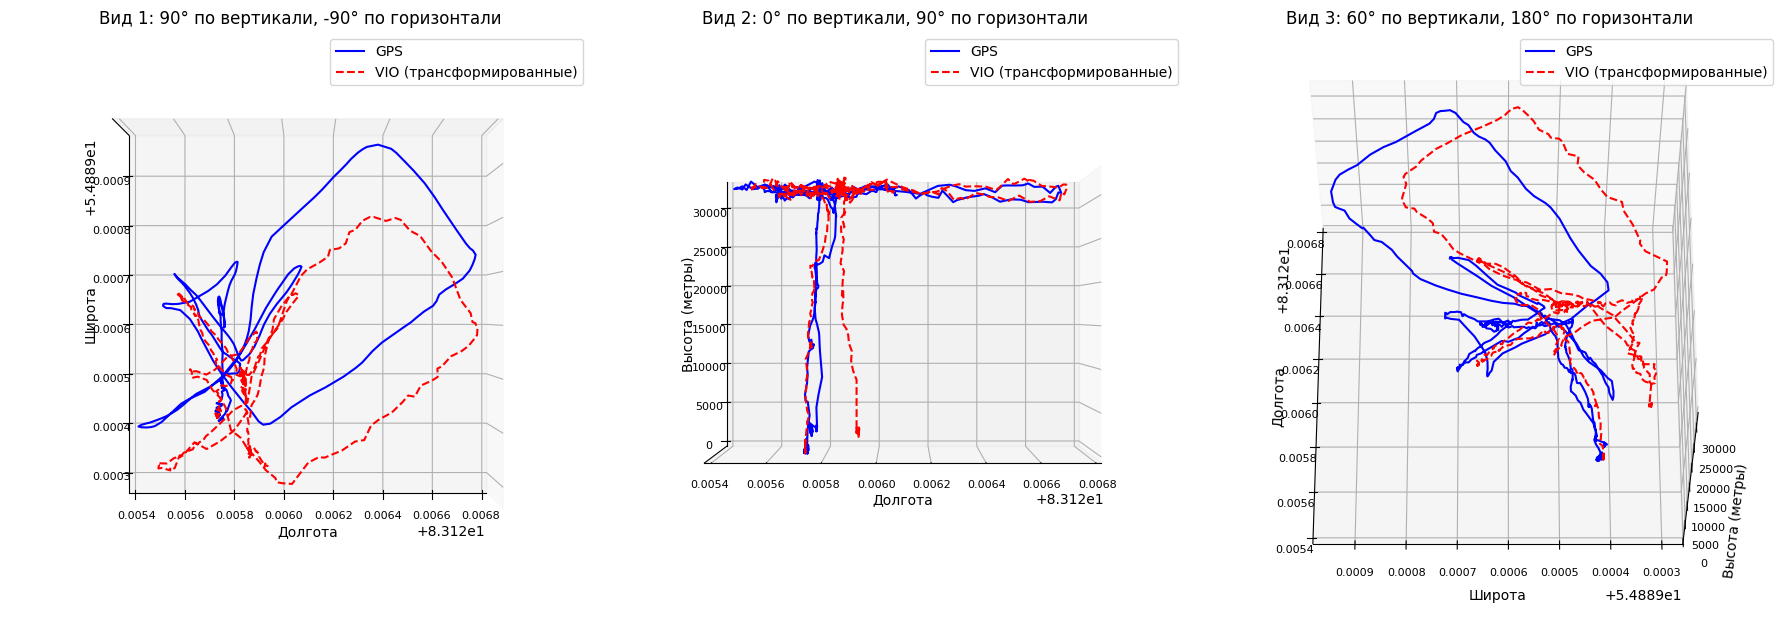

In [30]:
with nvtx.annotate("Draw Function", color="darkviolet"):
	draw_graph()

In [31]:
print(len(lat_GPS))
print(len(lat_VIO))

869
869
